In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree
from IPython.display import Image

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [20]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [3]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'BFcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'BFgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [4]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 75 
 gambiae samples: 92


In [5]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [6]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [7]:
del ann
#It will reduce the ammount of RAM used

In [8]:
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [9]:
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [10]:
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [11]:
# coluzzii
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [12]:
# gambiae. Because population is bigger than coluzzii I take randomly the same number of samples
random_index = random.sample(index_s, 75)
gs = {chrom: ga[chrom].take(random_index, axis=1) for chrom in contigs}

In [13]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [14]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [15]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 2278983
seg sites coluzii chrom 3R: 3201821
seg sites coluzii chrom 2R: 3312912
seg sites coluzii chrom 2L: 2748896
seg sites coluzii chrom X: 1108436


In [16]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 2516674
seg sites gambiae chrom 3R: 3443460
seg sites gambiae chrom 2R: 4030006
seg sites gambiae chrom 2L: 2891072
seg sites gambiae chrom X: 1258531


In [17]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [18]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [19]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [20]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [21]:
outgroups = ['chri']

In [22]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [23]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [24]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [25]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [26]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [27]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [28]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}
alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [29]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [30]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    alt[chrom] = alt_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom].compress(bool_aa_match[chrom], axis=0)
    pos_bial_genes[chrom] = pos_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom].compress(bool_aa_match[chrom], axis=0)

In [31]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [36]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [32]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [33]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [34]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [37]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([   82544,   138420,   138857,   139705,   168829,   296109,
         304874,   305123,   398426,   414547,  9205129,  9505086,
        9505172,  9505188,  9505301,  9663586, 10233123, 10233176,
       10233180, 10274453, 10274892, 10275447, 10276680, 10276868,
       10276878, 10276935, 10276969, 10276974, 10279245, 10387477,
       10762090, 10883390, 10883931, 10885668, 10885781, 10886677,
       10904449, 10905285, 10905431, 10905456, 10913315, 10913523,
       10954013, 11592016, 11592984, 11593841, 33285114, 33285780], dtype=int32)

In [38]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([   66609,    80272,    81082,    82766,   139762,   139768,
         296897,   303760,   304422,   304440,   305059,   377123,
         413508,   413550,   413551,   413944,  9251399,  9368190,
        9504837,  9509059,  9538409,  9662785,  9683196, 10243325,
       10243327, 10243798, 10279242, 10385594, 10386086, 10815293,
       10815812, 10862596, 10882689, 10885503, 10885515, 10904429,
       10904448, 10905461, 10912700, 10913305, 10913361, 10913397,
       11167839, 11241338, 11590859, 11591221, 11591569, 11591900,
       11592857, 11592996, 11593033, 11593158, 11593332, 11593543,
       11593718, 33285838], dtype=int32)

In [39]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [40]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [41]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [42]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [43]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [44]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [45]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001658,1,789,789.0
AGAP001674,7,2322,331.7142857142857
AGAP001675,1,115,115.0
AGAP001683,31,13434,433.35483870967744
AGAP001684,2,383,191.5


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001569,1,193,193.0
AGAP001674,1,3196,3196.0
AGAP001683,19,17075,898.6842105263158
AGAP001690,1,4164,4164.0
AGAP001824,13,10455,804.2307692307693


In [46]:
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [47]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [48]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [50]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/homogeneity_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [51]:
homog_tbl = (etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/homogen_test/homogeneity_summary_beta.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP001035,2.07294633432
X,AGAP000829,1.99065002755
X,AGAP000847,1.80006947926
X,AGAP000833,1.38208918675
X,AGAP000981,1.0312172389
X,AGAP000998,0.990614210027
X,AGAP000819,0.73670574503
X,AGAP001023,0.669584905448
X,AGAP001037,0.522771097348
X,AGAP001032,0.503968702696


-------------------------------

In [53]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [54]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP010313,5,112,22.4,3,175,58.333333333333336,3L
AGAP010317,4,31,7.75,1,28,28.0,3L
AGAP010781,1,487,487.0,1,366,366.0,3L
AGAP010788,2,1306,653.0,1,1144,1144.0,3L
AGAP004827,2,1101,550.5,3,829,276.3333333333333,2L


------------------------------

In [55]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP003997,2R,2.63593017938
AGAP001035,X,2.07294633432
AGAP000829,X,1.99065002755
AGAP001683,2R,1.80241055748
AGAP000847,X,1.80006947926
AGAP001674,2R,1.60213700223
AGAP000833,X,1.38208918675
AGAP000981,X,1.0312172389
AGAP000998,X,0.990614210027
AGAP001824,2R,0.770868865866


-------------------------

In [63]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP007736,3R,0.744627513867
AGAP001023,X,0.669584905448
AGAP004902,2L,0.506629749532
AGAP001083,X,0.389422347144
AGAP010295,3R,0.387374284988
AGAP000837,X,0.364596348531
AGAP001068,X,0.321596913499
AGAP001091,X,0.313509606913
AGAP004169,2R,0.273935789858
AGAP001076,X,0.266460301424


-------------------------

In [57]:
homogen_select_gambiae.rowlengths()

length,count
3,51


In [58]:
homogen_select_coluzzii.rowlengths()

length,count
3,78


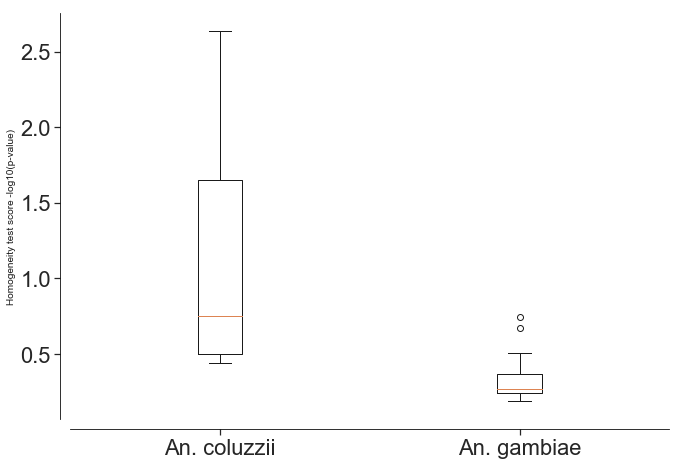

In [59]:
fig, ax = plt.subplots(figsize=(10,7))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

--------------------------------------

# HKA Test

In [65]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [66]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  189670.0 
 C genome wide:  660.0 
 A/C genome wide:  287.3787878787879

 B genome wide:  163402.0 
 D genome wide:  577.0 
 B/D genome wide:  283.19237435008665


In [67]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [68]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [69]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [70]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [71]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/gambiae_hka_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [72]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/coluzzii_hka_summary.tab_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


----------------------------------

In [3]:
hka_gambiae = etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/gambiae_hka_summary_beta.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP010313,175,3,1.7438325729
3R,AGAP010295,541,7,2.97932865354
3R,AGAP010294,95,3,3.60931541409
3R,AGAP010283,203,3,1.42837192458
3R,AGAP010308,58,5,18.8978164551
3R,AGAP007762,128,4,5.05799110639
3R,AGAP007737,117,6,13.7836407188
3R,AGAP007732,616,31,73.7207529799
3R,AGAP007736,2256,47,37.867950815
3R,AGAP007731,194,8,14.9445200716


In [4]:
hka_coluzzii = etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP010742,1949,1,1.36632782999
3L,AGAP010310,118,3,2.87634006266
3L,AGAP010788,1306,2,0.468704230489
3L,AGAP010313,112,5,9.84956210264
3L,AGAP010781,487,1,0.0539439997514
3L,AGAP010314,120,1,0.0450361502917
3L,AGAP010317,31,4,21.4591644894
3R,AGAP010295,502,3,0.24232785358
3R,AGAP010294,92,2,1.40073265877
3R,AGAP009805,1265,1,0.775036123759


-----------------------

## Disruptive selection
Also called diversifying selection, describes changes in population genetics in which extreme values for a trait are favored over intermediate values. In this case, the variance of the trait increases and the population is divided into two distinct groups. In this more individuals acquire peripheral character value at both ends of the distribution curve.



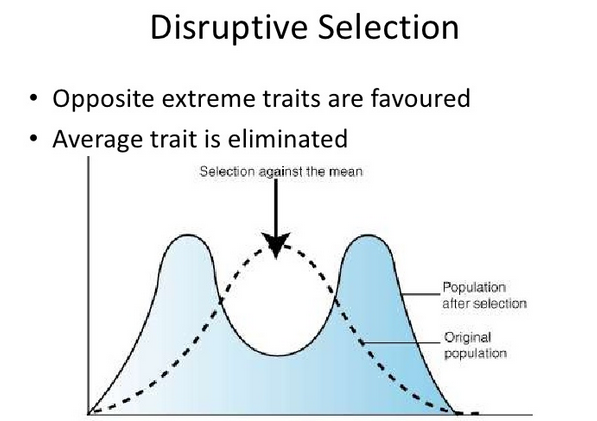

In [7]:
Image(filename='/home/randomx/Immagini/disruptive_sel.png')

In [9]:
disr_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
disr_select.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/putative_directional_selection_beta.tab', delimiter='\t')
disr_select.display(100)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP013341,37,10,116.282513332,33,4,19.9474744956,136.22998782759998
3R,AGAP007732,525,25,57.495478111,616,31,73.7207529799,131.2162310909
X,AGAP001035,67,13,116.542518984,113,5,9.58967973961,126.13219872361
X,AGAP001076,119,10,40.5525443667,80,10,58.3509711217,98.90351548839999
X,AGAP001023,177,6,8.94769671732,283,19,61.6862296845,70.63392640181999
3R,AGAP007736,1966,29,15.058507733,2256,47,37.867950815,52.926458548
X,AGAP001026,32,5,33.4001365679,38,4,17.4980133372,50.8981499051
3R,AGAP007731,146,10,33.0316878561,194,8,14.9445200716,47.9762079277
X,AGAP001037,17,4,36.1382158508,31,2,4.3110223446,40.4492381954
X,AGAP000819,18,4,34.472384907,41,2,3.27884079041,37.75122569741


In [10]:
disr_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
disr_select.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/putative_directional_selection_beta.tab', delimiter='\t')
disr_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP013341,37,10,116.282513332,33,4,19.9474744956,136.22998782759998
3R,AGAP007732,525,25,57.495478111,616,31,73.7207529799,131.2162310909
X,AGAP001076,119,10,40.5525443667,80,10,58.3509711217,98.90351548839999
3R,AGAP007736,1966,29,15.058507733,2256,47,37.867950815,52.926458548
X,AGAP001026,32,5,33.4001365679,38,4,17.4980133372,50.8981499051
3R,AGAP007731,146,10,33.0316878561,194,8,14.9445200716,47.9762079277


- AGAP007732 -> Solute Carrier Family 17
- AGAP013341 -> Specimen specific marker present in Neafsey 2010 and Aboagye-Antwi et. al 2015
- AGAP001076 -> CYP4G16 (Cytochrome P450 associated with insecticide resistance catalyzes cuticular hydrocarbon production in Anopheles gambiae)
- AGAP007736 -> Selection Atlas H12 Gabon (https://malariagen.github.io/agam-selection-atlas/0.1-alpha2/signal/H12/GAS/3/2/index.html)
- AGAP001026 -> Carboxypeptidase A  (Neafsey 2010)
- AGAP007731 -> ???

In the early version on phase1 genes found with score_c and score_g >= 10:

- AGAP001023 myofilin muscle protein involved in flight (before: <b>score_c = 15.96 | score_g = 14.34</b> ----- now: <b>score_c = 8.84 | score_g = 70.63</b>)
- AGAP001033 Protein mab-21-like (before: <b>score_c = 10.60 | score_g = 15.83</b> ----- now: <b>score_c = 9.06 | score_g = 9.73 </b>)
- AGAP001039 CYP307A1 (before: <b>score_c = 34.41 | score_g = 31.40 </b> ----- now: <b>score_c = 0.2 | score_g = 1.4 </b>)
- AGAP001050 chondroitin polymerizing factor Tripet (before: <b>score_c = 18.23 | score_g = 11.86 </b> ----- now: <b>score_c = 5.80 | score_g = 22.43 </b>)
- AGAP001053 The Coevolution of Insect Muscle TpnT and TpnI Gene Isoforms  (before: <b>score_c = 31.34 | score_g = 70.45 </b> ----- now: <b>score_c = 1.99 | score_g = 7.14 </b>)



## Genes which experienced private selection
Based on the hka-test score (1.3) here we indentify genes that there are only in one specimen

In [11]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)

In [13]:
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))

priv_sel_coluzzii.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/priv_sel_coluzzii.tab', delimiter='\t')
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000822,6,3,43.60784187,None,None,0
X,AGAP013181,30,5,35.3617250553,None,None,0
3L,AGAP010317,31,4,21.4591644894,28,1,0.672571683358
X,AGAP001031,16,3,20.5857330143,17,1,1.08359065663
3R,AGAP010302,42,4,16.1769208526,51,1,0.338725941884
X,AGAP001044,7,2,16.0409384341,17,1,1.08359065663
X,AGAP000833,81,5,13.792493708,203,2,0.444162760944
3R,AGAP010304,56,4,12.2441659849,None,None,0
2L,AGAP006634,14439,2,10.7362480363,None,None,0
X,AGAP001032,64,4,10.7201913983,106,2,1.1591295776


In [14]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/BFcol_vs_BFgam/priv_sel_gambiae.tab', delimiter='\t')
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,34,5,31.1350554672
X,AGAP001041,18,1,1.04331153921,16,3,20.2722378349
X,AGAP001051,None,None,0,7,2,15.8046526881
X,AGAP000949,None,None,0,48,4,14.006312147
X,AGAP001083,38,1,0.493605900955,26,3,13.1958828478
X,AGAP001042,None,None,0,11,2,10.9790390971
3R,AGAP010289,21,1,0.904142374557,16,2,7.94327927076
X,AGAP001047,30,1,0.63659022786,46,3,7.67017405314
2R,AGAP003070,None,None,0,8947,1,7.03978424325
X,AGAP001068,88,1,0.136356727117,102,4,6.49429145686


## Plot genome wide HKA
Representing that genes along the chromosome

In [15]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [16]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [17]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [31]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])

    sns.despine(offset=10)

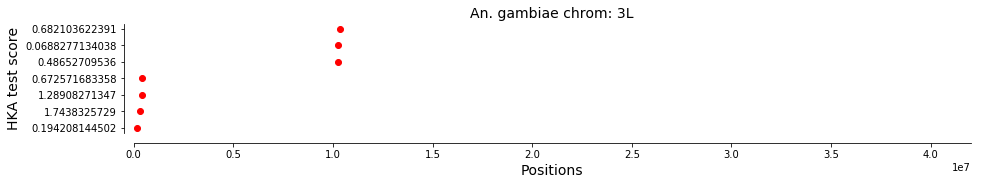

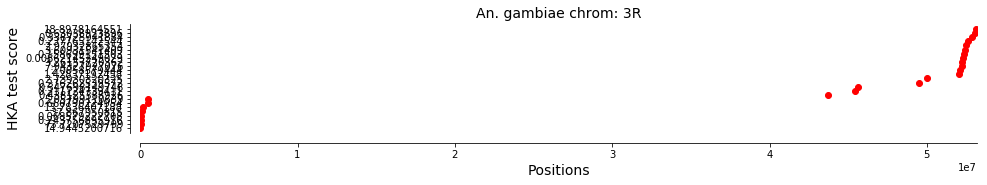

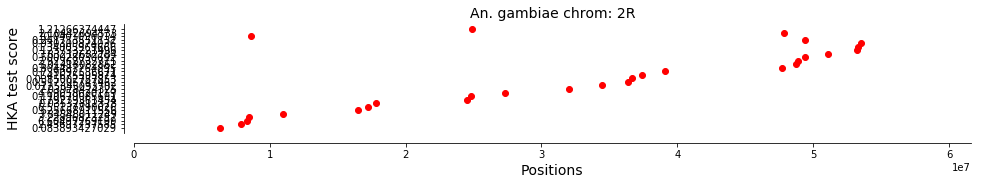

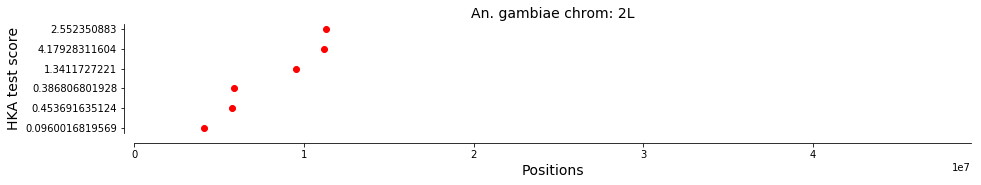

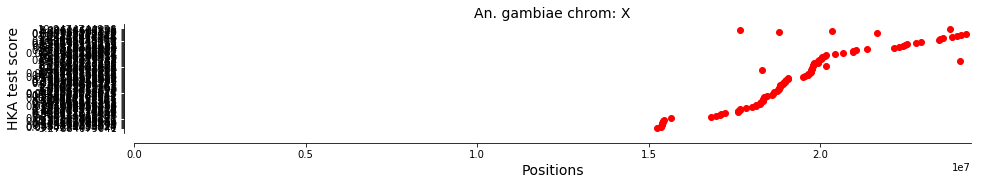

In [32]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

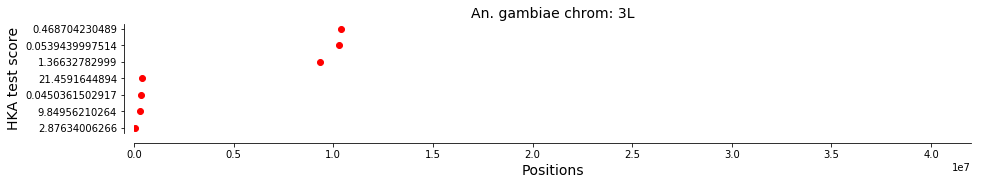

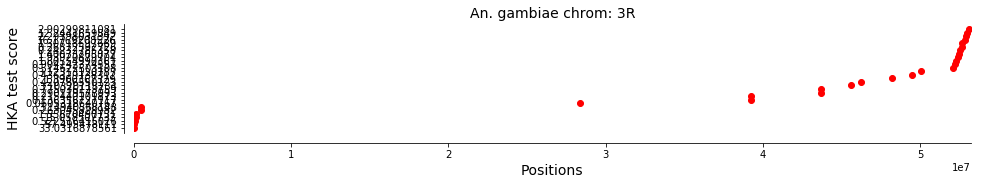

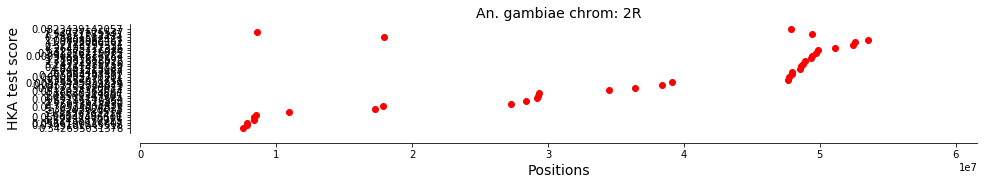

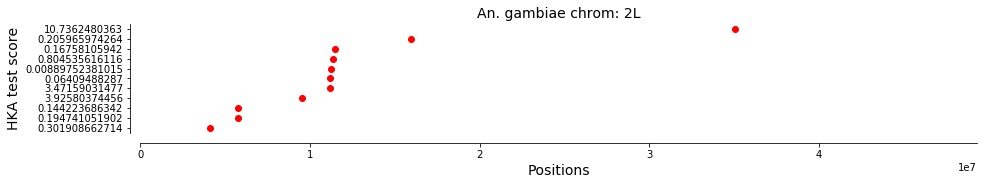

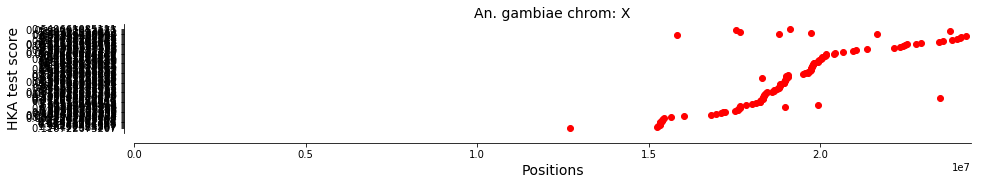

In [26]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)